### 1. 数据读入

In [1]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### 2. 数据归一化

In [2]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean())/column.std())

df = normalize_feature(df[['R&D Spend', 'Marketing Spend', 'Profit']])
df.head()

,R&D Spend,Marketing Spend,Profit
0,1.996146,2.132295,1.990990
1,1.936203,1.904267,1.979335
2,1.736731,1.610180,1.960934
3,1.539157,1.407916,1.758771
4,1.489812,1.268648,1.344094


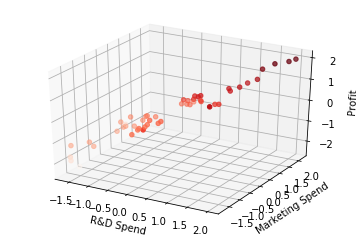

In [6]:
# 数据分析（3D）
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('R&D Spend')
ax.set_ylabel('Marketing Spend')
ax.set_zlabel('Profit')
ax.scatter3D(df['R&D Spend'], df['Marketing Spend'], df['Profit'], c=df['Profit'], cmap='Reds')

### 3. 数据处理

In [4]:
import numpy as np

# 为了方便矩阵相乘，添加一列全为1的x0
ones = pd.DataFrame({'ones': np.ones(len(df))})  # ones是n行1列的数据框，表示x0恒为1
df = pd.concat([ones, df], axis=1)  # 根据列合并数据

X_data = np.array(df[df.columns[0:3]])
Y_data = np.array(df[df.columns[-1]]).reshape(len(df), 1)

print(X_data.shape, type(X_data))
print(Y_data.shape, type(Y_data))
df.head()

(50, 3) <class 'numpy.ndarray'>
(50, 1) <class 'numpy.ndarray'>


,ones,R&D Spend,Marketing Spend,Profit
0,1.0,1.996146,2.132295,1.990990
1,1.0,1.936203,1.904267,1.979335
2,1.0,1.736731,1.610180,1.960934
3,1.0,1.539157,1.407916,1.758771
4,1.0,1.489812,1.268648,1.344094


### 4. 创建线性回归模型（数据流图）

In [5]:
import tensorflow as tf

tf.reset_default_graph() #  https://www.cnblogs.com/demo-deng/p/10365889.html

alpha = 0.01  # 学习率
epoch = 500 # 训练全量数据集的轮数

# 创建线性回归模型（数据流图）
# 输入X, 形状[50,3]
X = tf.placeholder(tf.float32, X_data.shape)
# 输入Y,形状[50,1]
Y = tf.placeholder(tf.float32, Y_data.shape)

# 权重变量W，形状[3,1]
# 存疑：tf.get_variable_scope().reuse_variables()  # https://cloud.tencent.com/developer/article/1335672
W = tf.get_variable("weights", (X_data.shape[1], 1), initializer=tf.constant_initializer())

# 假设函数 h(x) = w0*x0+w1*x1+w2*x2,其中x0恒为1
# 推理值 Y_pred 形状[47,1]
Y_pred = tf.matmul(X, W)

# 损失函数采用最小二乘法，Y_pred - y 是形如[47,1]的向量
# tf.matmul(a, b, transpose_a=True) 表示： 矩阵a的转置乘矩阵b,及[1,47] x [47,1]

# 损失函数操作 loss
loss_op = 1 / (2 * len(X_data)) * tf.matmul((Y_pred - Y), (Y_pred - Y), transpose_a=True)
# 随机梯度下降优化器 opt
opt = tf.train.GradientDescentOptimizer(learning_rate=alpha)
# 单步训练操作 train_op
train_op = opt.minimize(loss_op)

C:\Users\nwmsn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 5. 创建会话（运行环境）

In [17]:
# 创建会话（运行环境）
with tf.Session() as sess:
    # 初始化全局变量
    sess.run(tf.global_variables_initializer())
    # 开始训练模型
    # 因为训练集较小，所以不采用批梯度下降优化算法，每次都采用全量数据训练
    for e in range(1, epoch+1):
        sess.run(train_op, feed_dict={X: X_data, Y: Y_data})
        if e % 10 == 0:
            loss, w = sess.run([loss_op, W], feed_dict={X: X_data, Y: Y_data})
            log_str = "Epoch %d \t Loss=%.4g \t Model: y = %.4gx1 + %.4gx2 + %.4g"
            print(log_str % (e, loss, w[1], w[2], w[0]))

Epoch 10 	 Loss=0.3661 	 Model: y = 0.08908x1 + 0.06728x2 + -8.941e-10
Epoch 20 	 Loss=0.2775 	 Model: y = 0.1656x1 + 0.1226x2 + -4.098e-10
Epoch 30 	 Loss=0.2139 	 Model: y = 0.2315x1 + 0.1679x2 + 1.08e-09
Epoch 40 	 Loss=0.1682 	 Model: y = 0.2885x1 + 0.2047x2 + -6.706e-10
Epoch 50 	 Loss=0.1352 	 Model: y = 0.3378x1 + 0.2345x2 + -2.235e-10
Epoch 60 	 Loss=0.1113 	 Model: y = 0.3807x1 + 0.2583x2 + 3.725e-10
Epoch 70 	 Loss=0.09382 	 Model: y = 0.4181x1 + 0.2772x2 + -2.794e-10
Epoch 80 	 Loss=0.08101 	 Model: y = 0.4508x1 + 0.2919x2 + 1.863e-11
Epoch 90 	 Loss=0.07152 	 Model: y = 0.4796x1 + 0.3031x2 + 9.313e-10
Epoch 100 	 Loss=0.06441 	 Model: y = 0.505x1 + 0.3114x2 + 1.621e-09
Epoch 110 	 Loss=0.05901 	 Model: y = 0.5275x1 + 0.3173x2 + 2.403e-09
Epoch 120 	 Loss=0.05484 	 Model: y = 0.5476x1 + 0.3212x2 + 3.241e-09
Epoch 130 	 Loss=0.05157 	 Model: y = 0.5656x1 + 0.3235x2 + 3.669e-09
Epoch 140 	 Loss=0.04895 	 Model: y = 0.5818x1 + 0.3243x2 + 3.371e-09
Epoch 150 	 Loss=0.04681 	 Mod